# DISCLAIMER!
The data is fetched from https://github.com/pcm-dpc/COVID-19/ and they are provided from italian civil protection. The forecast models represents a simplification of the reality, and they do not pretend to have scientific validity (references in bottom). Accordingly to the documentation (https://github.com/pcm-dpc/COVID-19/wiki/1.it-Dati:-andamento-nazionale), the number of total cases, hospitalizations and intensive care is not cumulative, i.e. the number represents the people that are currently positive or in hospital/intensive care units. The data of the population comes from ISTAT open data (http://dati.istat.it).

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import sympy as sym
from sympy.core.evaluate import evaluate
import math

In [2]:
forecastDays= 20
defaultZone = 'Italia'
defaultFunc = 'logistic'

In [3]:
func = {
    'quartic': lambda x,a,b,c,d,e: a*x**4 + b*x**3 +c*x**2 + d*x + e,
    'cubic': lambda x,a,b,c,d: a*x**3 + b*x**2 +c*x + d,
    'quadratic': lambda x,a,b,c: a*x**2 + b*x +c,
    'linear': lambda x,a,b: a*x + b,
    'power': lambda x,a,b,c: a*x**b + c,
    'powerNorm': lambda x,a,b: x**a + b,
    'powerSum': lambda x,a,b,c: (x+a)**b + c,
    'exp': lambda x,a,b,c: a*b**x + c,
    'expNorm': lambda x,a,b: a**x + b,
    'expGrowth': lambda x,a,b,c: a*b**(x/c), #a: f(0); b: growth factor; c: time to increase by a factor of b
    'expGrowth2': lambda x,a,b,c,d: a*b**(x/c)+d,
    'expGrowthNorm': lambda x,a,b: a**(x/b),
    'expGrowthNorm2': lambda x,a,b: a*b**x,
    'expGrowthNorm3': lambda x,a: a**x,
    'logistic': lambda x,a,b,c: c/(1+np.exp(-(x-b)/a)), #a: speed; b: peak; c: end
    'gompertz': lambda x,a,b,c: c*(np.exp(-np.log(c/b)*np.exp(-a*x))), #a: speed; b: start; c: end
}

In [4]:
values = {
    'Total cases':'totale_casi',
    'Hospitalizations':'totale_ospedalizzati',
    'Intensive care':'terapia_intensiva',
    'Deceased':'deceduti',
         }

In [5]:
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sym.Number)})

In [6]:
def plotCurve(keys, zones=defaultZone, funcName=None, plotError=True, derivative=0, normalize=None):
    #normalize: None, 'population', 'swabs'
    ax = plt.axes()
    
    if not type(keys) is list:
        keys = [keys]
    if not type(zones) is list:
        zones = [zones]
        
    for zone in zones:
        for key in keys:
            if zone == 'Italia':
                data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
            else:
                data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-regioni/dpc-covid19-ita-regioni.csv')
                data = data[data.denominazione_regione == zone]

            x = np.array(np.linspace(1+54+derivative, len(data)+54, len(data)-derivative, dtype=float)) #start on 54th day of year
            y = np.array(data[values[key]], dtype=float)
            for _ in range(derivative):
                y = np.array([y[i]-y[i-1] for i in range(1,len(y))])
                
            if normalize == 'population':
                dataPop = pd.read_csv('DCIS_POPRES1_27032020185638165.csv')
                y = y / float(dataPop[dataPop.Territorio == zone].Value) * 100.
            
            elif normalize == 'swabs':
                y = y / np.array(data['tamponi'], dtype=float) * 100.
            
            if derivative > 0:
                plotLabel = "{}-{}\n(derivative {})".format(key, zone, derivative)
            else:
                plotLabel = "{}-{}".format(key, zone)
                
            xx = np.array(np.linspace(x[0], x[-1]+forecastDays, 50), dtype=float)
            dates = np.array(data['data'])

            plt.plot(x, y, 'o', label=plotLabel)

            if not funcName is None:
                try:
                    if funcName == 'logistic':
                        popt, pcov = sp.optimize.curve_fit(func[funcName], x, y, p0=[2,100,30000], maxfev=1000)
                        tex = '\\frac{{{}}}{{1+e^{{-(x-{})/{}}}}}'.format(round(popt[2],2),round(popt[1],2),round(popt[0],2))
                    else:
                        popt, pcov = sp.optimize.curve_fit(func[funcName], x, y)
                        #print(list(map(lambda v: '{0:.3f}'.format(v),popt)))

                        xs = sym.Symbol('x')
                        with evaluate(False):
                            #expr = func[funcName](sym.UnevaluatedExpr(xs),*(map(lambda v: round(v,2), popt)))
                            expr = func[funcName](xs,*(map(lambda v: round(v,2), popt)))
                        tex = sym.latex(expr).replace('$', '')
                        #tex = sym.latex(round_expr(func[funcName](xs,*popt), 3)).replace('$', '')

                    plt.plot(xx, func[funcName](xx, *popt), 'k')
                    if plotError:
                        errors = np.sqrt(np.diag(pcov))
                        nstd = 1.0
                        fit_up = popt + nstd * errors
                        fit_dw = popt - nstd * errors
                        fit_up_p = func[funcName](xx, *fit_up)
                        fit_dw_p = func[funcName](xx, *fit_dw)

                        plt.fill_between(xx, fit_up_p, fit_dw_p, alpha=.35, color="gray")

                except RuntimeError as e:
                    print(e)
                    tex = 'ERROR'

    if not funcName is None:
        plt.title('$f(x)= {}$\n{} - {}'.format(tex, dates[0], dates[-1]),fontsize=16)
    else:
        plt.title('{} - {}'.format(dates[0], dates[-1]),fontsize=16)
        
    plt.legend(loc = 'upper left')
    if normalize is None:
        plt.ylabel('persons')
    elif normalize == 'population':
        plt.ylabel('% of population')
    elif normalize == 'swabs':
        plt.ylabel('% of swabs')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()
    plt.grid(which='minor', alpha=0.2)
    ax.minorticks_on()
    plt.grid()
    plt.show()

# Plots

## Total cases

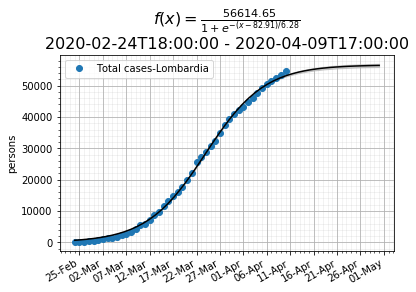

In [7]:
plotCurve('Total cases', 'Lombardia', funcName=defaultFunc)

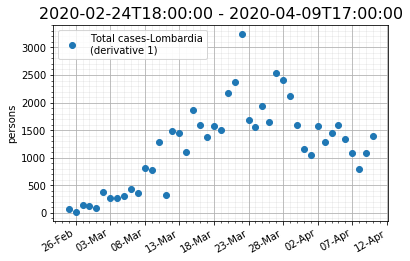

In [8]:
plotCurve('Total cases', 'Lombardia', derivative=1)

---

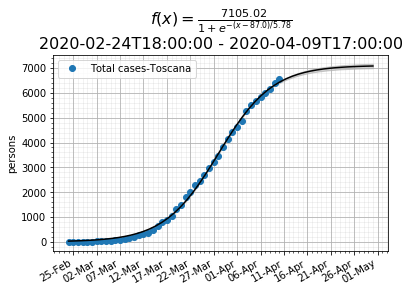

In [9]:
plotCurve('Total cases', 'Toscana', funcName=defaultFunc)

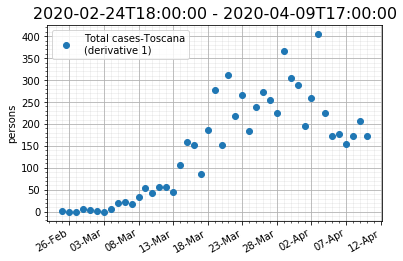

In [10]:
plotCurve('Total cases', 'Toscana', derivative=1)

---

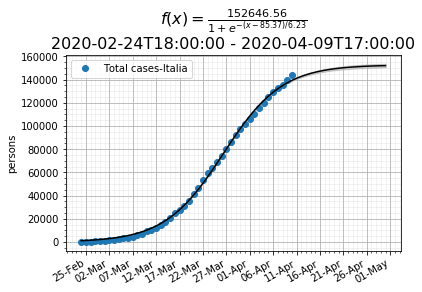

In [11]:
plotCurve('Total cases', funcName=defaultFunc)

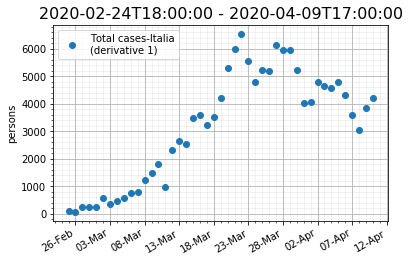

In [12]:
plotCurve('Total cases', derivative=1)

---

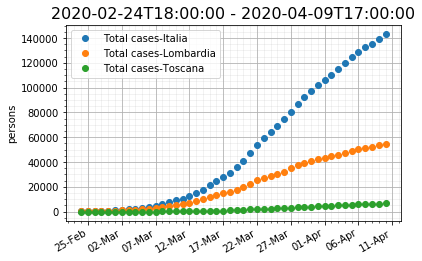

In [13]:
plotCurve('Total cases', ['Italia','Lombardia','Toscana'])

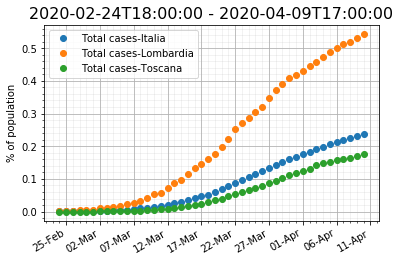

In [14]:
plotCurve('Total cases', ['Italia','Lombardia','Toscana'], normalize='population')

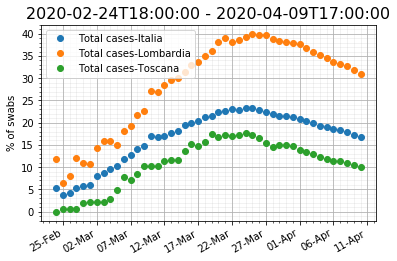

In [15]:
plotCurve('Total cases', ['Italia','Lombardia','Toscana'], normalize='swabs')

## Hospitalizations

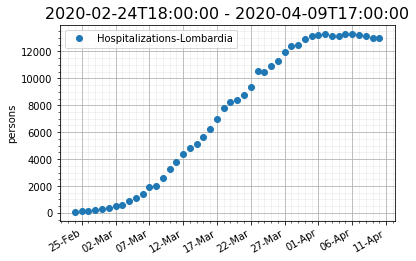

In [16]:
plotCurve('Hospitalizations', 'Lombardia')

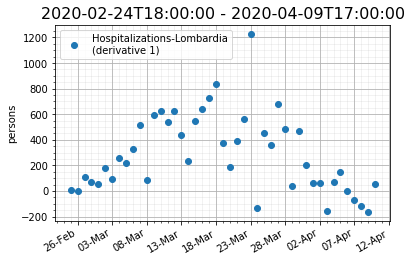

In [17]:
plotCurve('Hospitalizations', 'Lombardia', derivative=1)

---

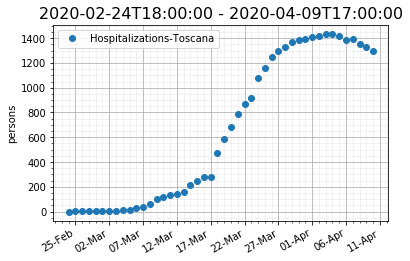

In [18]:
plotCurve('Hospitalizations', 'Toscana')

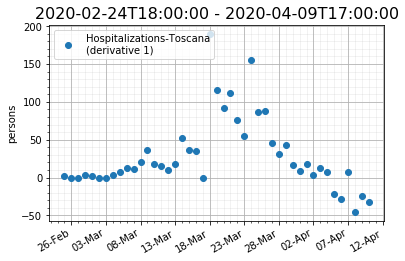

In [19]:
plotCurve('Hospitalizations', 'Toscana', derivative=1)

---

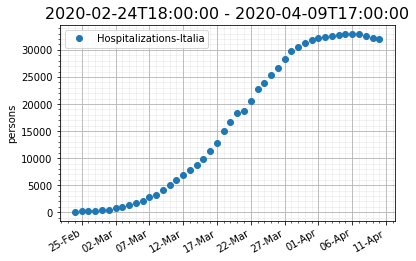

In [20]:
plotCurve('Hospitalizations')

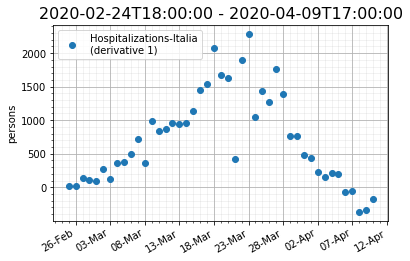

In [21]:
plotCurve('Hospitalizations', derivative=1)

---

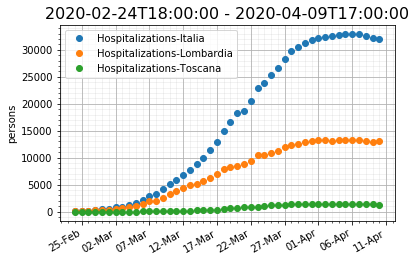

In [22]:
plotCurve('Hospitalizations', ['Italia','Lombardia','Toscana'])

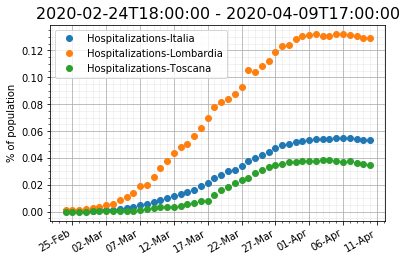

In [23]:
plotCurve('Hospitalizations', ['Italia','Lombardia','Toscana'], normalize='population')

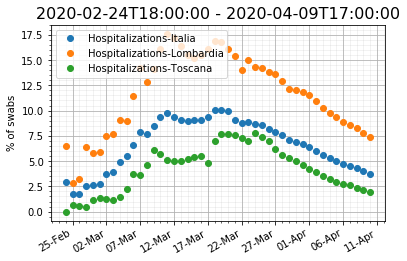

In [24]:
plotCurve('Hospitalizations', ['Italia','Lombardia','Toscana'], normalize='swabs')

## Intensive care

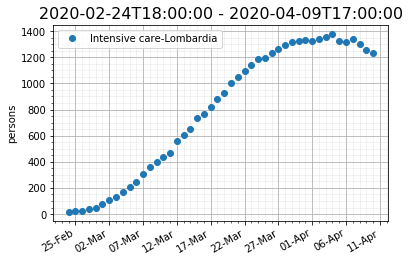

In [25]:
plotCurve('Intensive care', 'Lombardia')

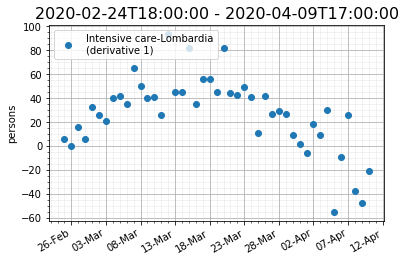

In [26]:
plotCurve('Intensive care', 'Lombardia', derivative=1)

---

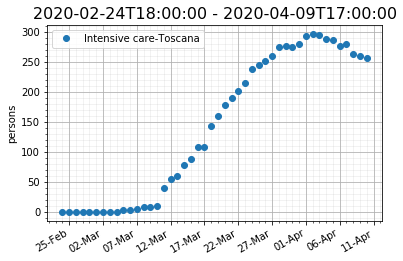

In [27]:
plotCurve('Intensive care', 'Toscana')

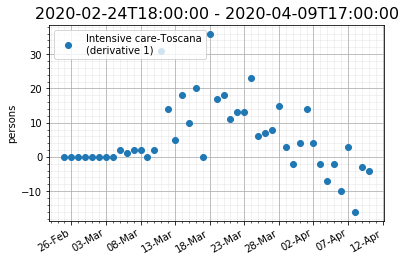

In [28]:
plotCurve('Intensive care', 'Toscana', derivative=1)

---

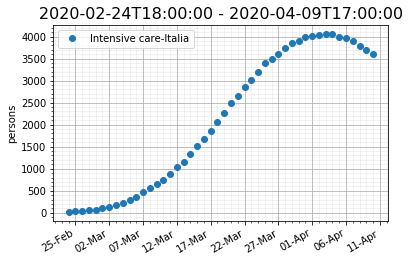

In [29]:
plotCurve('Intensive care')

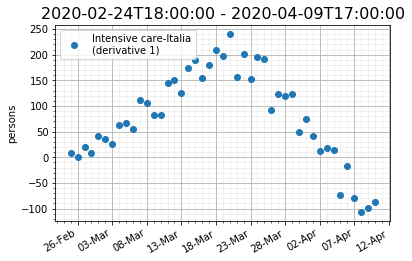

In [30]:
plotCurve('Intensive care', derivative=1)

---

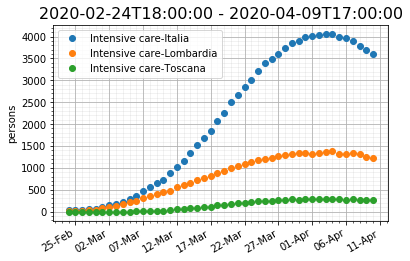

In [31]:
plotCurve('Intensive care', ['Italia','Lombardia','Toscana'])

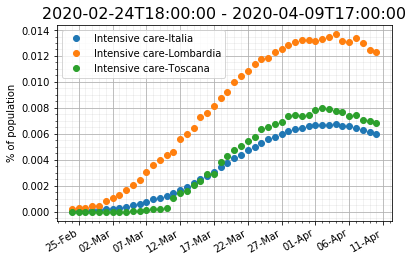

In [32]:
plotCurve('Intensive care', ['Italia','Lombardia','Toscana'], normalize='population')

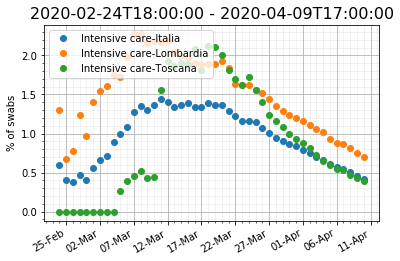

In [33]:
plotCurve('Intensive care', ['Italia','Lombardia','Toscana'], normalize='swabs')

## Deceased

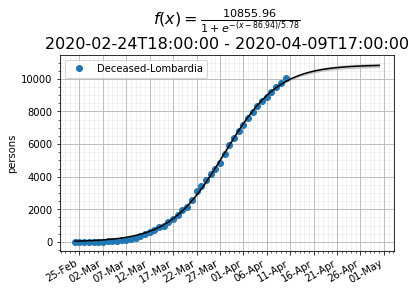

In [34]:
plotCurve('Deceased', 'Lombardia', funcName=defaultFunc)

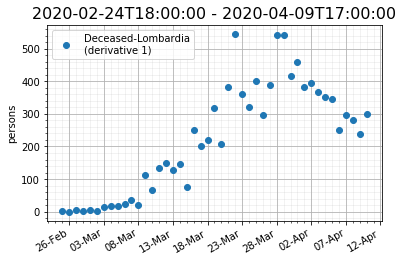

In [35]:
plotCurve('Deceased', 'Lombardia', derivative=1)

---

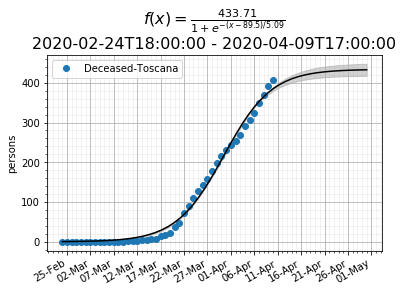

In [36]:
plotCurve('Deceased', 'Toscana', funcName=defaultFunc)

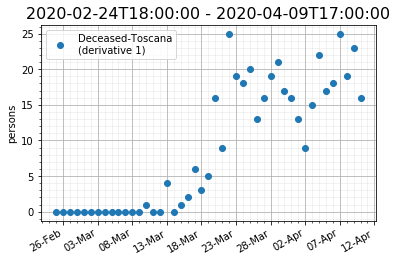

In [37]:
plotCurve('Deceased', 'Toscana', derivative=1)

---

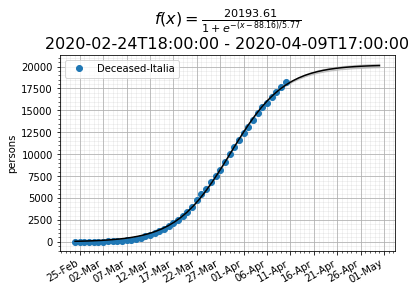

In [38]:
plotCurve('Deceased', funcName=defaultFunc)

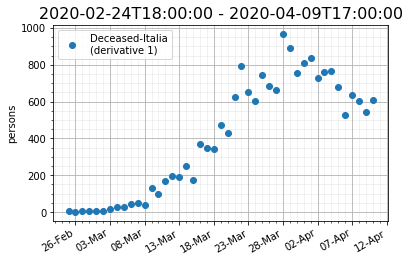

In [39]:
plotCurve('Deceased', derivative=1)

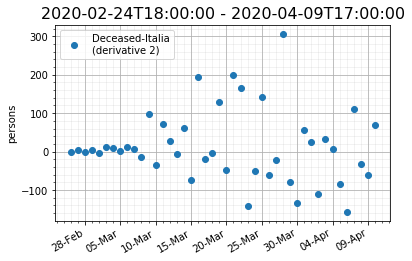

In [40]:
plotCurve('Deceased', derivative=2)

---

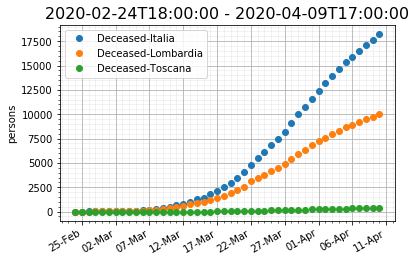

In [41]:
plotCurve('Deceased', ['Italia','Lombardia','Toscana'])

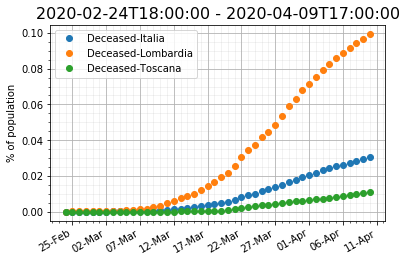

In [42]:
plotCurve('Deceased', ['Italia','Lombardia','Toscana'], normalize='population')

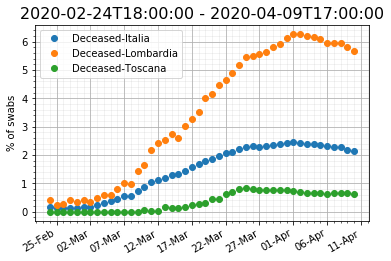

In [43]:
plotCurve('Deceased', ['Italia','Lombardia','Toscana'], normalize='swabs')

# Compare

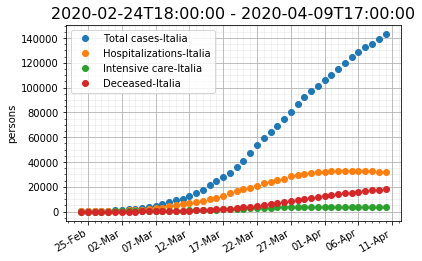

In [44]:
plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Italia')

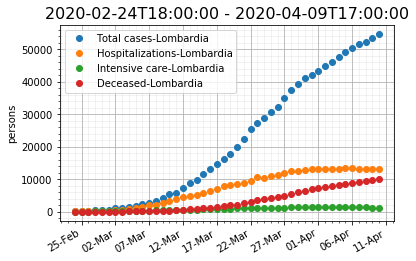

In [45]:
plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Lombardia')

In [46]:
#plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Emilia Romagna')

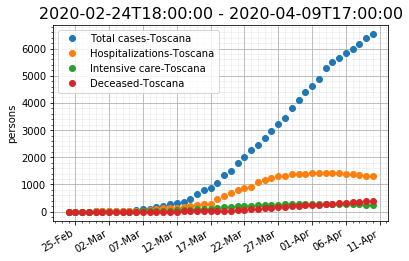

In [47]:
plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Toscana')

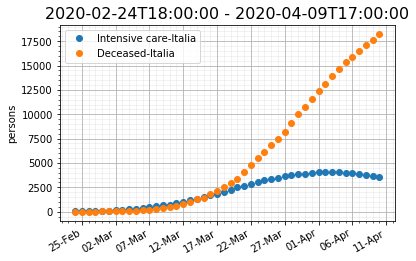

In [48]:
plotCurve(['Intensive care','Deceased'], 'Italia')

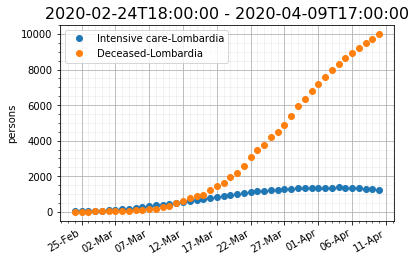

In [49]:
plotCurve(['Intensive care','Deceased'], 'Lombardia')

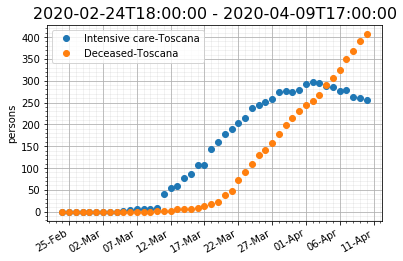

In [50]:
plotCurve(['Intensive care','Deceased'], 'Toscana')

### References
* https://colab.research.google.com/drive/1EprvUCsrqeJOeuXHuQfY_iiO4Dw8NH5q?fbclid=IwAR0j2KjgX9ffrys4P0su036gmYSvDMAuCuwCUd1vNN7qlwmQvX8r0ZdpUpc#scrollTo=nZKHXDxcfegX
* https://avatorl.org/covid-19/?page=GrowthRateAndForecast
* http://opendatadpc.maps.arcgis.com/apps/opsdashboard/index.html#/b0c68bce2cce478eaac82fe38d4138b1
* https://github.com/pcm-dpc/COVID-19/
* https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be
* https://doi.org/10.1101/2020.02.16.20023606